This notebook can be used for making and visualizing the images of the XYZeq datasets. You can choose which stats and which color channels to map to which values of the sequencing data.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import cv2
from PIL import Image

from scipy import stats

import warnings
from tqdm.notebook import tqdm
import itertools as it
import pickle as pkl
import os

In [2]:
%config Completer.use_jedi = False

## 1. Read in Adata and Spatial Barcodes

In [3]:
adata = sc.read_h5ad('/myvol/data2/deep2/concat.deep.adata.m.and.h.combatted.dimred.subsetted.dimred.h5ad')

In [4]:
spatial = pd.read_csv('/myvol/data2/plate23_map.csv', header=None, index_col=0)
spatial.columns = ['X','Y']

In [5]:
spatial

,X,Y
0,,
AGTTGTTCTAGCGCCT,1,1
CCGTTAGACGTGACAG,1,2
CTTACGGTCCGTACGT,1,3
TCCTGCATTGTGAGAA,1,4
CTGCGCACTGCTTCTT,1,5
...,...,...
CCTGTTGTATGGTTAC,44,2
TCAATCTATGAGTCGC,44,3
TCGCGACTGCCACTAC,44,4


In [6]:
spatial.iloc[-20:,:]

,X,Y
0,,
CGCACTATAGGTTAAG,42,11
ATCGCGGTTCCTGAGG,42,12
AGTAGAGTTATCGTCC,42,13
GCTTGACCGTAATCGA,42,14
CGGCTCATTACTGCGG,42,15
GGACGCCTACAATGAT,42,16
TACATCGACGAACCTG,42,17
AGCGGAGAGTCAAGCT,42,18
GCATCCAATCGCGTTA,43,1


X indices 43 and 44 don't have a full set of Y indices. These indices are on the edge of the array and are complicating some of the operations further downstream. Because I've examined some of the outputs and they do not seem to be terribly useful anyway (probably contain very few cells), I'm going to drop them for now. I will do this after I add the columns to the `adata.obs`.

In [7]:
adata.obs['spatial_bc'] = [i.split('.')[1].split('-')[0] for i in adata.obs_names]

In [8]:
adata.obs['X'] = list(map(lambda x: spatial.loc[x,'X'], adata.obs['spatial_bc']))
adata.obs['Y'] = list(map(lambda x: spatial.loc[x,'Y'], adata.obs['spatial_bc']))

In [9]:
sum(adata.obs['X'] > 42)

26

Only 26 cells across 5 batches in these wells. Let's just drop them.

In [10]:
adata = adata[adata.obs['X'] <= 42].copy()

I'm also only going to use the first 4 batches, since the last batch was actually from the same exact slice (and I've confirmed after examining outputs that they are almost identical). We could possibly merge them into one output (now more cells for the combined batch) but not sure if that'd be explainable, since we technically tried to enrich for CD8s and it just didn't work.

In [11]:
adata = adata[adata.obs['batch'] != '4'].copy()

## 2. Build the HexMap
Instead of relying on matplotlib, for many reasons I've decided to just build the image manually using a numpy array.

When considering the hexagons:
1. We want something as small as possible because for super resolution we will be registering to _pixel_ resolution. 
2. We need something that stacks. I don't know the theory or jargon around this, but I've determined (mostly through trial and error) we need something with an even number of pixels per side to prevent single-pixel points on the sides, as those don't stack.

I've come to the conclusion that the smallest, most-hexagon-like figure we can generate is the one that fits inside a 12 x 12 pixel grid.

In [12]:
myhex = np.zeros((12,12)) 

In [13]:
myhex[0:1,3:9] = 1
myhex[1:3,2:10] = 1
myhex[3:5,1:11] = 1
myhex[5:7,:12] = 1
myhex[7:9,1:11] = 1
myhex[9:11,2:10] = 1
myhex[11:12,3:9] = 1

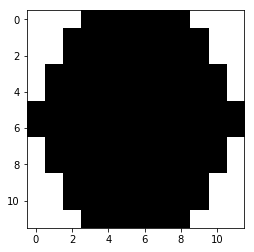

In [14]:
plt.imshow(myhex, cmap='binary');

Our hexagon has 6 pixel-long sides on top and bottom. If it were a true hexagon, the pixels on the vertical sides would also be 6 units long. We can try to measure one by using the length of the right triangle formed from the 3 pixels jutting out and 6 pixels high, which ends up creating a hypotenuse vertical side of theortical 6.71 units long, so 6 ~ 6.7, I'd say is close enough (~10% off) to true hexagon. The 12-pixel-long hexagon also has the added benefit of spatial resolution to around the diameter of a cell (500/12 is 40 um, roughly the size of what I'd imagine are the largest cells we'll be picking up). 

Now building the array of hexagons. I will mark the location of key points of each hexagons in a lookup dataframe called `hex_coords` so I don't have to build it everytime I need to fill in new values.

In [15]:
# make a lookup table, so that I don't have to do all these calculations again
hex_coords = pd.DataFrame(0,index=pd.MultiIndex.from_product([range(1,43), range(1,19)], names=['X','Y']),
                          columns=['hex_xstart','hex_ystart', 'center_xstart', 'center_ystart', 'hex_xend', 'hex_yend'])

for y, x in it.product(range(1,19),range(1,43)):
    xstart = int(6*(x-1)*1.5) # please don't ask me how I figured this equation out, it works
    ystart = (y-1)*12
    if x % 2 == 0:  
        ystart = ystart + 6

    # make a lookup table, so that I don't have to do all these calculations again
    hex_coords.loc[(x,y),'hex_xstart'] = xstart
    hex_coords.loc[(x,y),'hex_ystart'] = ystart
    hex_coords.loc[(x,y),'center_xstart'] = xstart + 5
    hex_coords.loc[(x,y),'center_ystart'] = ystart + 5
    hex_coords.loc[(x,y),'hex_xend'] = xstart + 12
    hex_coords.loc[(x,y),'hex_yend'] = ystart + 12
# hex_coords = hex_coords.astype(np.uint8) # definitely don't convert to integers, it will mess things up, not quite sure how exactly at the current moment

Now fill in the hex array with random colors to show it works.

In [19]:
img = list()
for color in ['r','g','b']:
    hex_array = np.zeros((222,381)) # these are calculated to perfectly encapsulate the 19 x 43 well array
    for y, x in it.product(range(1,19),range(1,43)):
        
        val = np.random.choice(range(50,255))
        
        xstart = hex_coords.loc[(x,y),'hex_xstart']
        ystart = hex_coords.loc[(x,y),'hex_ystart']

        yend = hex_coords.loc[(x,y),'hex_yend']
        xend = hex_coords.loc[(x,y),'hex_xend']
        
        current_hex = hex_array[ystart:yend,xstart:xend]
        hex_array[ystart:yend,xstart:xend] = np.where(myhex, val, current_hex)
    img.append(hex_array)
img = np.stack(img, axis=2).astype(np.uint8)

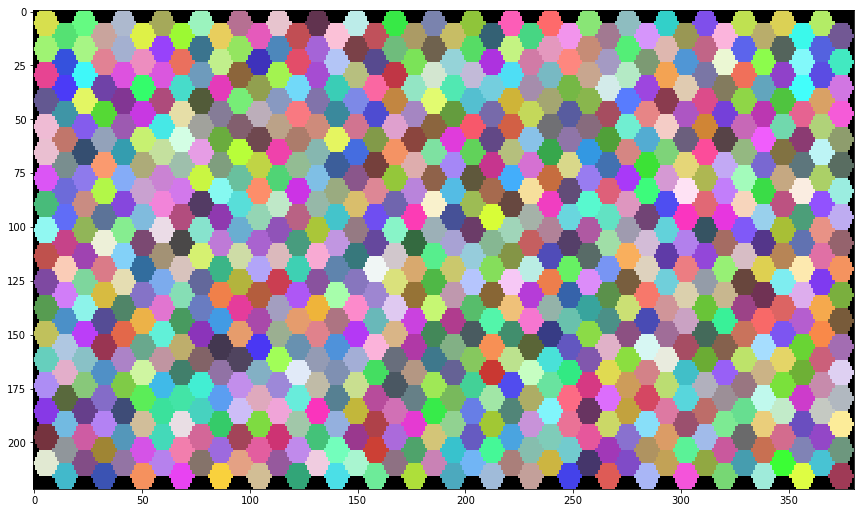

In [20]:
plt.figure(figsize=(400/25,220/25)) # chose this size to keep the aspect ratio
plt.imshow(img, cmap='binary');

I would also like to make a list of immediate neighbors for each well for use later.

In [21]:
neighbors_list = list()
for x, y in it.product(range(1,43), range(1,19)):
    if x % 2 == 0:
        neighbors = np.array([(x-1, y+1), (x, y+1), (x+1, y+1), (x-1, y), (x+1, y), (x, y-1)])
    else:
        
        neighbors = np.array([(x-1, y-1), (x, y-1), (x+1, y-1), (x-1, y), (x+1, y), (x, y+1)])
        
    neighbors = np.array([i for i in neighbors if not np.any(i == 0)
                         and not np.any(i[0] > 42) 
                         and not np.any(i[1] > 18)]) # remove those that are outside array bounds
    
    neighbors_list.append(neighbors)
hex_coords['neighbors'] = neighbors_list    

## 3. Make Images

There are several ways to make images. The two methods we wanted to try first are as follows:

1. Using the percentage of cells in a well that are MC38 vs Hepatocytes as the pixel value 
2. Using the counts of transcripts in cells across the most differentially expressed genes. 

Method 1 is simpler, but method 2 may provide more information. 

### 3.1 Method 1

#### Build a Counts DataFrame

In [59]:
batches = adata.obs['batch'].values.unique()

In [60]:
celltypes = adata.obs['celltype1'].unique()

In [61]:
celltypes

[Hepato, Immune, Human, MC38, Liver Special]
Categories (5, object): [Hepato, Immune, Human, MC38, Liver Special]

Initialize a counts dataframe that will contain the counts, per well and per batch, of each cell type. I'm going to use `pd.MultiIndex` to index according to `X`, `Y`, and `batch`. The MultiIndex, while useful, also causes some problems with by creating these indices of dtype `Category` that are hard to edit later. I try to remedy those issues by converting the columns to a regular index here, and then set the batch to an integer dtype after I build the counts dataframe. Converting to the batch to an integer is useful later.

In [62]:
counts = pd.DataFrame(0,index=pd.MultiIndex.from_product([batches,range(1,43),range(1,19)],names=['batch','X','Y']),columns=celltypes)
counts.columns = pd.Index(list(counts.columns)) # this is to convert the columns into a normal index and not a categorical index, not sure why it does that when using multiindex.from_product

In [63]:
counts.columns

Index(['Hepato', 'Immune', 'Human', 'MC38', 'Liver Special'], dtype='object')

Subset the adata into smaller adatas according to their batch.

In [64]:
adata_subs = dict()

In [65]:
for batch in batches:
    adata_subs[batch] = adata[adata.obs['batch'] == batch].copy()

Fill the counts dataframe.

In [66]:
for batch, x, y in tqdm(counts.index):
    xy_cts = adata_subs[batch][(adata_subs[batch].obs['X'] == x) & (adata_subs[batch].obs['Y'] == y)].obs['celltype1']
    cts, ct_counts = np.unique(xy_cts.values, return_counts=True)
    for ct, ct_count in zip(cts, ct_counts):
        counts.loc[(batch, x, y),ct] = ct_count

This is where I convert the batch to an integer, it makes things easier later.

In [67]:
counts.index = counts.index.set_levels([counts.index.levels[0].astype(np.uint8), counts.index.levels[1], counts.index.levels[2]])

#### Fill in the Hexarray with Color Values

In [68]:
def get_colors(df, method=1, cts=None):
    '''
    This function takes in the counts DataFrame and will generate color values based on 
    whatever metric you choose.
    '''
    if method == 1:
        ### Percentage hepato or mc38 (out of hepato + mc38)
        mc38 = df['MC38'].values
        hep = df['Hepato'].values
        clip_val = 0 # clip values to 5
        mc38 = np.where(mc38 < clip_val, 0, mc38)   
        hep = np.where(hep < clip_val, 0, hep)   
        warnings.filterwarnings('ignore')
        p_hep = hep/(hep + mc38)
        warnings.filterwarnings('default')
        colors = np.stack([255*p_hep, np.zeros((len(p_hep),)), 255*(1-p_hep)], axis=1).astype(np.uint8)
        
    elif method == 2:
        ### Number of One Cell Type
        ct = cts[0]
        ct = df[ct].values
        clip_val = 0 # clip values to 5
        ct = np.where(ct < clip_val, 0, ct)      
        colors = np.stack([255*ct, np.zeros((len(ct),)), np.zeros((len(ct),))], axis=1).astype(np.uint8)
        
    elif method == 3:
        ### Number of Two Cell Types
        ct1, ct2 = tuple(cts)
        ct1 = df[ct1].values
        ct2 = df[ct2].values
        clip_val = 0 # clip values to 5
        ct1 = np.where(ct1 < clip_val, 0, ct1)      
        ct2 = np.where(ct2 < clip_val, 0, ct2) 
        colors = np.stack([255*ct1, np.zeros((len(ct1),)), 255*ct2], axis=1).astype(np.uint8)
    
    elif method == 4:
        ### Number of Three Cell Types
        ct1, ct2, ct3 = tuple(cts)
        ct1 = df[ct1].values
        ct2 = df[ct2].values
        ct3 = df[ct3].values
        clip_val = 3 # clip values to 5
        ct1 = np.where(ct1 < clip_val, 0, ct1)      
        ct2 = np.where(ct2 < clip_val, 0, ct2) 
        ct3 = np.where(ct3 < clip_val, 0, ct3) 
        colors = np.stack([255*ct1, 255*ct2, 255*ct3], axis=1).astype(np.uint8)
    
    newdf = pd.DataFrame(colors,index=df.index,columns=['r','g','b'])
#     newdf = newdf[newdf.sum(axis=1) != 0] # do not include this, just fill the whole thing, I thought to include it to reduce time but it causes problems later

    return newdf

In [69]:
def get_image(color_df):
    '''
    color_df is a dataframe with columns 'r', 'g', and 'b', corresponding to the color values
    that should be filled into each hexagon.
    '''
    img = list()
    for color in ['r','g','b']:
        hex_array = np.zeros((222,399))
        for y, x in it.product(range(1,19),range(1,45)):

            try:
                val = color_df.loc[(x, y), color]
            except: # I should make this exception more specific
                continue

            xstart = hex_coords.loc[(x,y),'hex_xstart']
            ystart = hex_coords.loc[(x,y),'hex_ystart']

            yend = hex_coords.loc[(x,y),'hex_yend']
            xend = hex_coords.loc[(x,y),'hex_xend']

            current_hex = hex_array[ystart:yend,xstart:xend]
            hex_array[ystart:yend,xstart:xend] = np.where(myhex, val, current_hex)
        img.append(hex_array)
    img = np.stack(img, axis=2).astype(np.uint8)
    return img

In [70]:
img_list = list()
for batch in tqdm(counts.index.get_level_values('batch').unique()):
    images = list()
    color_df = get_colors(counts.loc[batch])
    img = get_image(color_df)
    img_list.append(img)

L10C
L20C1
L20T
L30C

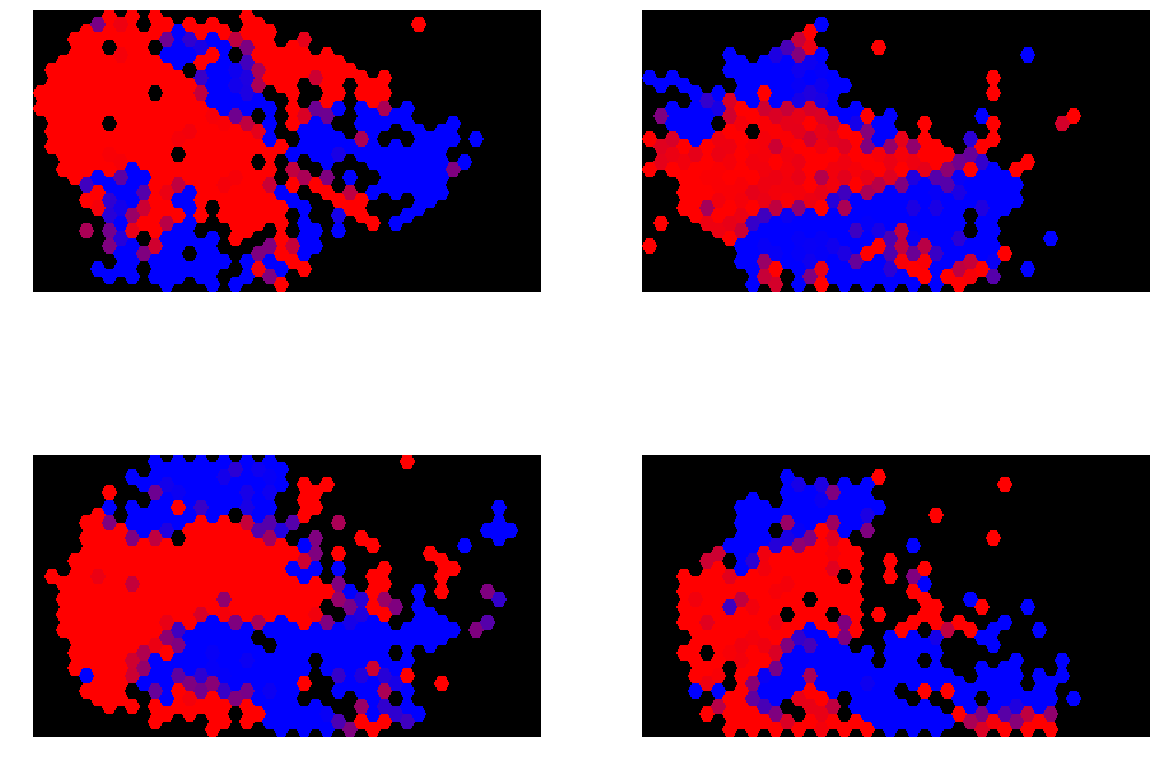

In [71]:
fig, axes = plt.subplots(2,2, figsize=(20,15))
for img, ax in zip(img_list, np.ravel(axes)):
    ax.imshow(img);
    ax.axis('off')
np.ravel(axes)[-1].axis('off');

### Analysis

I want to show the spatial dependence of the wells: those that are next to each other are likely to contain similar number of hepatocytes/MC38.

In [72]:
counts = counts.join(hex_coords['neighbors'])

In [73]:
mc38 = counts['MC38'].values
hep = counts['Hepato'].values
tot = hep + mc38

In [74]:
clip_val = 0 # clip values to 5
mc38 = np.where(mc38 < clip_val, 0, mc38)   
hep = np.where(hep < clip_val, 0, hep)

In [75]:
warnings.filterwarnings('ignore')
p_hep = np.nan_to_num(hep/(tot))
p_mc38 = np.nan_to_num(mc38/(tot))
warnings.filterwarnings('default')

In [76]:
counts['Tot'] = tot
counts['%Hep'] = p_hep
counts['%MC38'] = p_mc38

In [77]:
counts.head()

Hepato  Immune  Human  MC38  Liver Special  \
X Y batch                                               
1 1 0           0       0      1     0              0   
    1           0       0      0     0              0   
    2           0       0      0     0              0   
    3           0       0      0     0              0   
  2 0           0       0      0     0              0   

                                  neighbors  Tot  %Hep  %MC38  
X Y batch                                                      
1 1 0                      [[2, 1], [1, 2]]    0   0.0    0.0  
    1                      [[2, 1], [1, 2]]    0   0.0    0.0  
    2                      [[2, 1], [1, 2]]    0   0.0    0.0  
    3                      [[2, 1], [1, 2]]    0   0.0    0.0  
  2 0      [[1, 1], [2, 1], [2, 2], [1, 3]]    0   0.0    0.0

Here I'm going to correlate the percentage hepatocyte in each well with the mean percentage hepatocyte of its immediate neighbors. I'm only going to consider wells with at least `min_cells` cells and that have at least `min_nonzeros` non-zero immediate neighbors with at least `min_cells_per_neighbor` cells each.

In [85]:
min_cells = 3
min_nonzeros = 2 # max 6 neighbors per well
min_cells_per_neighbor = 3

In [79]:
# doing percent hepato
n_means = list() # means of neighbors
n_vars = list() # variances of neighbors

for i in tqdm(counts.index):
    
    # check if the well in question has at least min_cells
    if counts.loc[i,'Tot'] < min_cells:
        n_means.append(-1)
        n_vars.append(-1)
        continue
    

    # define useful variables
    batch = i[-1]
    n_list = list()
    idxs = list()
    
    for n_i in counts.loc[i, 'neighbors']: # for the n_i = index of each neighbor
        idxs.append(tuple(np.append(n_i, batch)))
    
    # subset the counts dataframe
    counts_sub = counts.loc[idxs]
    
    # make a mask for nonzero wells
    nonzero_mask = counts_sub['Tot'] != 0
    
    if nonzero_mask.sum() >= min_nonzeros: # check that we have enough nonzero neighbors
        # only use those neighbors that are nonzero
        counts_sub = counts_sub.loc[nonzero_mask]
        
        # only use those 
        counts_sub = counts_sub[counts_sub['Tot'] > min_cells_per_neighbor]
        if len(counts_sub) == 0:
            # Don't take the mean of an empty slice or variance of a slice of length 1
            # Really only need this when num_nonzeros == 0
            n_means.append(-1)
            n_vars.append(-1)
            continue
        elif len(counts_sub) == 1:
            n_means.append(counts_sub['%Hep'].mean())
            n_vars.append(0)
            continue
        mean = counts_sub['%Hep'].mean()
        var = counts_sub['%Hep'].var()
        n_means.append(mean)
        n_vars.append(var)
    else:
        n_means.append(-1)
        n_vars.append(-1)
        continue

In [86]:
counts['n_means'] = n_means
counts['n_vars'] = n_vars

In [87]:
a = counts[(counts['n_means'] != -1) & # I've marked ones that we don't want to include or that would have produced a NaN as having a mean of -1, so get rid of those
           (counts['%Hep'] != 0) & # we only want mixed wells, so not %Hepatocyte == 0
           (counts['%Hep'] != 1)] # we only want mixed wells, so not %Hepatocyte == 1

In [88]:
a.shape

(352, 11)

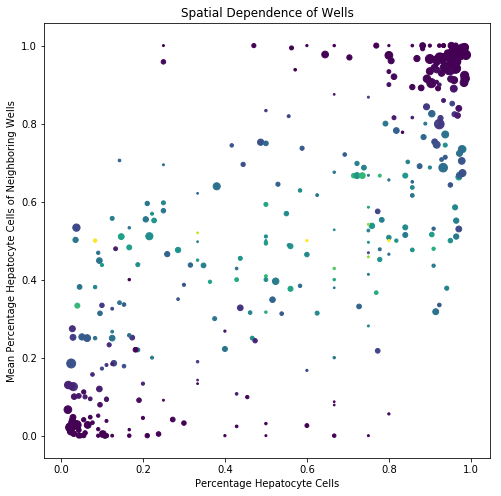

In [89]:
plt.figure(figsize=(8,8))
plt.scatter(a['%Hep'].values, a['n_means'].values, s=a['Tot'], c=a['n_vars'].values);
plt.title('Spatial Dependence of Wells')
plt.xlabel('Percentage Hepatocyte Cells')
plt.ylabel('Mean Percentage Hepatocyte Cells of Neighboring Wells');

In [90]:
a.corr().loc['%Hep','n_means']

0.7684001903735547

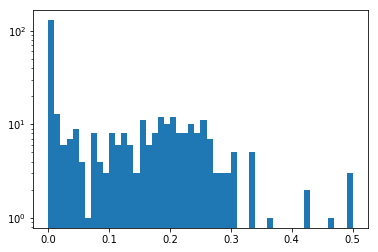

In [136]:
plt.hist(a['n_vars'].values,bins=50);
plt.yscale('log')

I'd like to show that the number of wells with high variance increases towards the center of the distribution (at around 50%).

In [91]:
thresh = 0.05
bin_size = 0.04

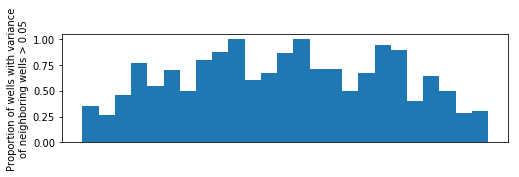

In [92]:
bins = np.arange(0.0, 1 + bin_size, bin_size)
vals = list()
plt.figure(figsize=(8,2))
for i in range(len(bins) - 1):
    a_sub = a[(a['%Hep'] >= bins[i]) & (a['%Hep'] < bins[i+1])]
    vals.append((a_sub['n_vars'] > thresh).sum()/len(a_sub))
plt.bar(bins[:-1] + bin_size/2, vals, width=bin_size);
plt.ylabel('Proportion of wells with variance\nof neighboring wells > %s' % thresh)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

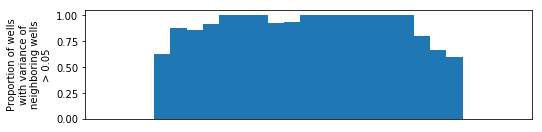

In [93]:
bins = np.arange(0.0, 1 + bin_size, bin_size)
vals = list()
plt.figure(figsize=(8,2))
for i in range(len(bins) - 1):
    a_sub = a[(a['n_means'] >= bins[i]) & (a['n_means'] < bins[i+1])]
    vals.append((a_sub['n_vars'] > thresh).sum()/len(a_sub))
plt.bar(bins[:-1] + bin_size/2, vals, width=bin_size);
plt.ylabel('Proportion of wells\nwith variance of\nneighboring wells\n> %s' % thresh)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

The plot looks like it would fit a logit curve. I will try to fit it to one.

In [94]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [95]:
def func(x, a, b):
    return a*(np.log((x/(1-x))) + b)

In [96]:
popt, pcov = curve_fit(func, a['%Hep'].values, a['n_means'].values)

In [99]:
r2_score(a['n_means'].values, np.apply_along_axis(func, 0, a['%Hep'].values, *popt))

0.5998848250100088

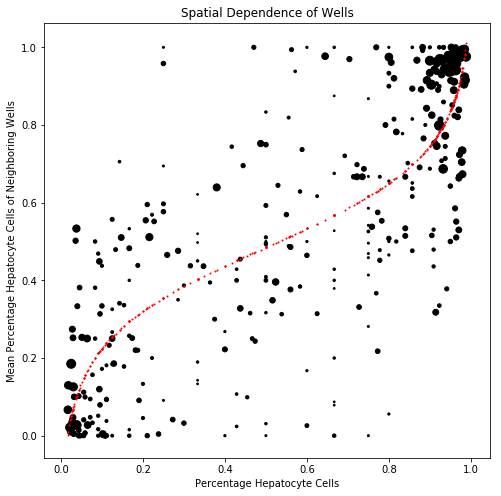

In [101]:
plt.figure(figsize=(8,8))
plt.scatter(a['%Hep'].values, a['n_means'].values, s=a['Tot'], c='k');
plt.scatter(a['%Hep'].values, np.apply_along_axis(func, 0, a['%Hep'].values, *popt), s=1, c='red')
plt.title('Spatial Dependence of Wells')
plt.xlabel('Percentage Hepatocyte Cells')
plt.ylabel('Mean Percentage Hepatocyte Cells of Neighboring Wells');

### 3.2 Method 2

#### Build a Counts DataFrame

This method uses a list of differentially expressed genes between MC38 and Hepatocytes to mark the regions. The benefit of this method is that we now have a much larger set of images to use for alignment.

In [102]:
with open('/myvol/data2/deep2/reg_genes_dict.pkl','rb') as file:
    genes_dict = pkl.load(file)

Make a flat list from the dictionary:

In [103]:
genes = [i for j in list(genes_dict.values()) for i in j]

Confirm that the genes are unique:

In [104]:
print(len(genes))
print(len(np.unique(genes)))

386
386


In [105]:
adata_sub = adata[:,genes].copy()

In [106]:
adata_subs = dict()

In [107]:
batches = adata_sub.obs['batch'].values.unique()

In [108]:
for batch in batches:
    adata_subs[batch] = adata_sub[adata_sub.obs['batch'] == batch].copy()

In [117]:
counts = pd.DataFrame(0,index=pd.MultiIndex.from_product([batches,range(1,43),range(1,19)],names=['batch','X','Y']),columns=genes)

In [118]:
for batch, x, y in tqdm(counts.index):
    xyadata = adata_subs[batch][(adata_subs[batch].obs['X'] == x) & (adata_subs[batch].obs['Y'] == y)].copy()
    for i in range(len(counts.columns)):
        gene = genes[i]
        # try block here is to avoid an index error with obs_vector, it fails when the number of observations is 1
        # at that point, the .X underlying array is a single row by # of genes, so just choose the value as the sum
        try: 
            counts.loc[(batch, x, y),gene] = xyadata.obs_vector(gene).sum()
        except IndexError:
            counts.loc[(batch, x, y),gene] = xyadata.X[i]

This took a while to fill in so I'm going to dump it into a pkl.

In [119]:
# with open('/myvol/data2/deep2/counts.pkl', 'wb') as file:
#     pkl.dump(counts,file)
with open('/myvol/data2/deep2/counts.pkl', 'rb') as file:
    counts = pkl.load(file)

#### Fill in the Hexarray with Color Values

In [120]:
def get_colors(s):
    '''
    So this function I found is a nice way to divide up the bimodal distribution of the pixel values generated from gene values.
    Block 1 generates a distribution where a huge mode gets generated right at the where the negative distribution ends.
    Block 2 finds where that mode and clips anything below it to zero, then rescales to 255.
    Together, they produce a nice distribution that matches the histology slides.
    '''
    # Block 1
    colors = s.values
    colors = (colors - colors.min())
    colors /= colors.max()
    colors *= 255
    
    # Block 2
    n, bins, patches = plt.hist(colors,bins=256);
    plt.close()
    offset = bins[n.argmax()+1]
    colors -= offset
    colors = np.clip(colors,0,colors.max())
    colors /= colors.max()
    colors *= 255
    
    s = pd.Series(colors,index=s.index,name='color')
    s = s[s!=0].copy()
    
    return s

In [121]:
def get_image(colors):
    '''
    df is a dataframe with multiindex of names X and Y, and a single column containing the counts of the genes in each well
    '''
    
    df = hex_coords.join(colors)
    df.dropna(inplace=True) # I would convert nans to zeros anyways, and my array is going to be initialized with zeros anyway
    
    img = np.zeros((222,399)) # this was the calculated size of my 12 pixel hexagons perfectly stacked
    
    for i in df.index:
        hex_ystart = int(df.loc[i,'hex_ystart'])
        hex_yend = hex_ystart + 12

        hex_xstart = int(df.loc[i,'hex_xstart'])
        hex_xend = hex_xstart + 12
        
        current_hex = img[hex_ystart:hex_yend,hex_xstart:hex_xend]
        img[hex_ystart:hex_yend, hex_xstart:hex_xend] = np.where(myhex, df.loc[i,'color'], current_hex)
    return img

In [145]:
images_list = list()
for batch in tqdm(counts.index.get_level_values('batch').unique()):
    images = list()
    for gene in tqdm(counts.loc[batch].columns):
        colors = get_colors(counts.loc[batch, gene])
        img = get_image(colors)
        images.append(img) # make the nans zeros

    # using an array of csr_matrices will save a ton of memory, since these images are zero inflated
    images_list.append(np.array(list(map(csr_matrix,images))))

This took a while to build so I'm going to dump it into a pkl. I will do analysis in a separate notebook.

In [146]:
with open('/myvol/data2/deep2/images.pkl', 'wb') as file:
    pkl.dump(images_list,file)